In [119]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cPickle as pickle
import scipy.io
import time
import ssn
import ks_test3
# from hyperopt import fmin, tpe, hp, STATUS_OK

%matplotlib inline

Elapsed time to load maps: 0 seconds


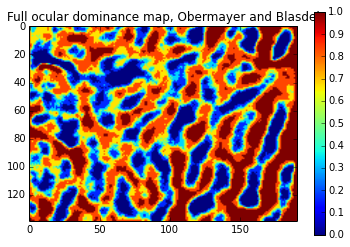

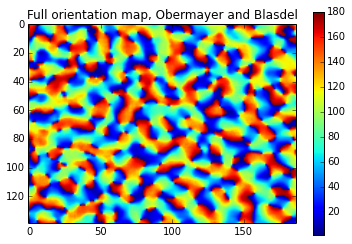

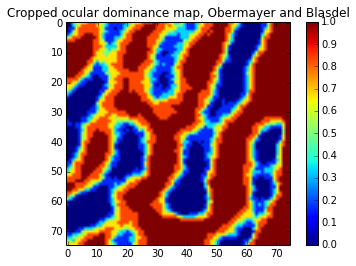

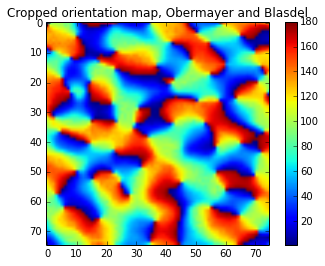

In [114]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-7.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)

# subsample the Blasdel images to get (approximately) the right scale of OD map
# inds = np.round(np.linspace(0,OD_map.shape[0], N_pairs, False)).astype(int)
# OD_map_cropped = OD_map[inds[:,np.newaxis],inds+OD_map.shape[1]-OD_map.shape[0]]

plt.figure()
plt.imshow(OD_map_full)
plt.colorbar()
plt.title('Full ocular dominance map, Obermayer and Blasdel')

plt.figure()
plt.imshow(OP_map_full)
plt.colorbar()
plt.title('Full orientation map, Obermayer and Blasdel')

OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

plt.figure()
plt.imshow(OD_map)
plt.colorbar()
plt.title('Cropped ocular dominance map, Obermayer and Blasdel')

plt.figure()
plt.imshow(OP_map)
plt.colorbar()
plt.title('Cropped orientation map, Obermayer and Blasdel')

In [3]:
# SSN parameters
N_pairs = 75
field_size = 16.
dx = field_size/N_pairs

sig_FF = 32
sig_RF = dx

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5

# kappa_E = 0.18
# kappa_I = .85

# Original connection weights from Rubin et al., 2015:
J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

# J_EE = 0.1
# J_IE = 0.38
# J_EI = 0.1
# J_II = 0.086

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45
sig_OD = .25

[W_EE, W_IE, W_EI, W_II] = ssn.generate_connetion_weights( N_pairs, field_size, OP_map, kappa_E, kappa_I, J_EE, J_IE, J_EI, J_II, sig_EE, sig_IE, sig_EI, sig_II, sig_ori )

Mean no. of connections:
u_EE: 20	 u_IE: 41	 u_EI: 33	 u_II: 33
Omega_E:  1345.46
Omega_I:  77138.2
System may not show strong nonlinear behaviour.


In [9]:
# Randomly select n units for analysis
n_units = 75
selected_units = np.floor( N_pairs*np.random.rand(n_units,2) )

In [5]:
# Sanity check: verify that we still see some SSN behaviour with the Blasdel maps
contrast_range_ssn = np.linspace(3,50,10)
ssn_contrast_results = np.zeros((len(selected_units), len(contrast_range_ssn), 2, N_pairs, N_pairs))
ff_ssn_stim = np.zeros((n_units, N_pairs, N_pairs))

for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ff_ssn_stim[i,:,:] = ssn.generate_mono_stimulus(OP_map[yi,xi], 1, [xi*dx, yi*dx], OP_map, full_frame=True ) 

In [6]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# SSN only:
dt = 0.005
timesteps = 100

start_time = time.time()

for i in range(len(selected_units)):
    for j in range(len(contrast_range_ssn)):
        xi = selected_units[i,0]
        yi = selected_units[i,1]
        c = contrast_range_ssn[j]
        h = ff_ssn_stim[i,:,:]
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        ssn_contrast_results[i,j,0] = r_E[-1,:,:]
        ssn_contrast_results[i,j,1] = r_I[-1,:,:]
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 5350 seconds.


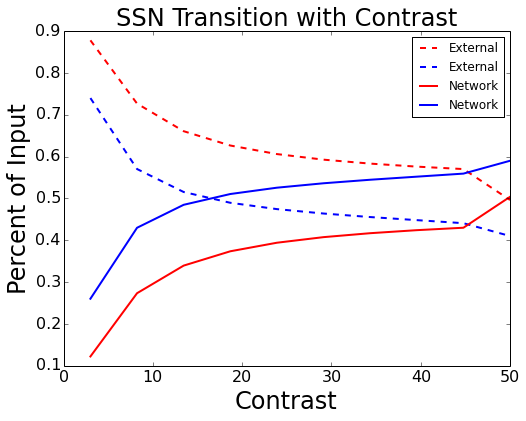

In [8]:
# plot reproductions of figure 6B: SSN only
ssn_E_external = np.zeros((len(selected_units), len(contrast_range_ssn)))
ssn_I_external = np.copy(ssn_E_external)
ssn_E_network = np.copy(ssn_E_external)
ssn_I_network = np.copy(ssn_E_external)

for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    for j in range(len(contrast_range_ssn)):
        ssn_E_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*W_EE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*W_EI[yi+xi*N_pairs,:,:])
        ssn_I_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*W_IE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*W_II[yi+xi*N_pairs,:,:])
        ssn_E_external[i,j] = np.sum(ff_ssn_stim[i,yi,xi]*contrast_range_ssn[j])
        
ssn_external_avg = np.mean(ssn_E_external,0)
ssn_E_net_avg = np.mean(ssn_E_network,0)
ssn_I_net_avg = np.mean(ssn_I_network,0)

plt.figure(figsize=(8, 6))
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_E_net_avg+ssn_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_I_net_avg+ssn_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_E_net_avg/(ssn_E_net_avg+ssn_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_ssn, ssn_I_net_avg/(ssn_I_net_avg+ssn_external_avg), 'b', linewidth=2, label="Network")
plt.title('SSN Transition with Contrast', fontsize=24)
plt.xlabel('Contrast', fontsize=24)
plt.ylabel('Percent of Input', fontsize=24)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(fontsize=12)
# plt.savefig('ssn_transition.eps', format='eps', dpi=1000)

In [13]:
# first find the summation field size (optimal CRF stimulus) for each unit (both E and I)
stim_sizes = np.linspace(0.5, 4.5, 10)
crf_bank = np.zeros( (n_units, 2, len(stim_sizes), N_pairs, N_pairs) )

for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ocularity = np.round( OD_map[yi,xi] )
    ori = OP_map[yi,xi]
    for j in range(len(stim_sizes)):
        crf_bank[i,0,j,:,:] = ssn.generate_mono_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map )
        crf_bank[i,1,j,:,:] = ssn.generate_ext_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map, OD_map, ocularity)

c = 40
dt = 0.005
timesteps = 100

In [14]:
# Store the summation field sizes (SFS) for both E and I units

sfs_E_full = np.zeros((N_pairs, N_pairs))
sfs_I_full = np.copy(sfs_E_full)

sfs_E = np.zeros( n_units )
sfs_I = np.copy(sfs_E)
sfs_mono_E = np.copy(sfs_E)
sfs_mono_I = np.copy(sfs_E)
max_fr_E = np.copy(sfs_E)
max_fr_I = np.copy(sfs_E)
max_fr_mono_E = np.copy(sfs_E)
max_fr_mono_I = np.copy(sfs_E)

In [15]:
start_time = time.time()

# run to find binocular SFS:
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    e_found = False
    i_found = False
    for j in range(len(stim_sizes)):
        
        if e_found == True and i_found == True:
            break
        
        h = crf_bank[i,0,j,:,:]
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        
        if r_E[-1,yi,xi] >= max_fr_E[i]:
            max_fr_E[i] = r_E[-1,yi,xi]
            sfs_E[i] = stim_sizes[j]
        else:
            e_found = True
            
        if r_I[-1,yi,xi] >= max_fr_I[i]:
            max_fr_I[i] = r_I[-1,yi,xi]
            sfs_I[i] = stim_sizes[j]
        else:
            i_found = True

# run to find monocular SFS:
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    e_found = False
    i_found = False
    for j in range(len(stim_sizes)):
        
        if e_found == True and i_found == True:
            break
        
        h = crf_bank[i,1,j,:,:]
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        
        if r_E[-1,yi,xi] >= max_fr_mono_E[i]:
            max_fr_mono_E[i] = r_E[-1,yi,xi]
            sfs_mono_E[i] = stim_sizes[j]
        else:
            e_found = True
            
        if r_I[-1,yi,xi] >= max_fr_mono_I[i]:
            max_fr_mono_I[i] = r_I[-1,yi,xi]
            sfs_mono_I[i] = stim_sizes[j]
        else:
            i_found = True
            
print "Elapsed time: %d seconds" % (time.time() - start_time)

Elapsed time: 22410 seconds


In [16]:
print max_fr_mono_I
print '-----------------'
print max_fr_mono_E

[ 0.          0.44444444  0.44444444  0.          2.22222222  0.          0.
  0.          0.          0.          0.          0.88888889  0.44444444
  0.          0.          0.          0.          0.          0.44444444
  0.          0.          0.          0.         -0.88888889  0.          0.
  0.          0.          0.          0.44444444  0.          0.          0.
  0.          0.          0.44444444  0.          0.          0.
  0.44444444  0.44444444  1.33333333  0.          0.44444444  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.77777778  0.44444444  0.          0.          0.44444444
  0.          0.          0.44444444  0.          0.          0.44444444
  0.          0.88888889  0.        ]


In [ ]:
OD_prefs = np.zeros(len(selected_units))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    OD_prefs[i] = OD_map[yi,xi]
    
print OD_prefs

In [ ]:
non_dom_stimuli = np.zeros((len(selected_units), 2, N_pairs, N_pairs))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ocularity = np.abs( np.round(OD_prefs[i]) - 1)
    non_dom_stimuli[i,0,:,:] = ssn.generate_ext_stimulus( ori, sfs_E[i], [dx*xi, dx*yi], OP_map, OD_map, ocularity)
    if sfs_E[i] != sfs_I[i]:
        non_dom_stimuli[i,1,:,:] = ssn.generate_ext_stimulus( ori, sfs_I[i], [dx*xi, dx*yi], OP_map, OD_map, ocularity)
    

In [ ]:
non_dom_results = np.zeros((len(selected_units), 2))
st = time.time()
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    h = non_dom_stimuli[i,0,:,:]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    non_dom_results[i,0] = r_E[-1,yi,xi]
    non_dom_results[i,1] = r_I[-1,yi,xi]
    if sfs_E[i] != sfs_I[i]:
        h = non_dom_stimuli[i,1,:,:]
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        non_dom_results[i,1] = r_I[-1,yi,xi]
        
print "Elapsed time: %d seconds" % (time.time()-st)

In [ ]:
print "E unit firing rates for non dominant eye stimulus: "
print non_dom_results[:,0]
print "Max: ", np.max(non_dom_results[:,0])
print '-----------'
print "I unit firing rates for non dominant eye stimulus: "
print non_dom_results[:,1]
print "Max: ", np.max(non_dom_results[:,1])

In [ ]:
threshold = 1 # threshold for firing rate 
print "E units above threshold: %d" % len(selected_units[np.where(non_dom_results[:,0]>=threshold),:][0])
print selected_units[np.where(non_dom_results[:,0]>=threshold),:]
print '-----------'
print "I units above threshold: %d" % len(selected_units[np.where(non_dom_results[:,1]>=threshold),:][0])
print selected_units[np.where(non_dom_results[:,1]>=threshold),:]

thresh_units_E = selected_units[np.where(non_dom_results[:,0]>=threshold),:][0]
thresh_units_I = selected_units[np.where(non_dom_results[:,1]>=threshold),:][0]

thresh_units_sfs_E = sfs_E[np.where(non_dom_results[:,0]>=threshold)]
thresh_units_sfs_I = sfs_I[np.where(non_dom_results[:,1]>=threshold)]

thresh_units_max_fr_E = max_fr_E[np.where(non_dom_results[:,0]>=threshold)]
thresh_units_max_fr_I = max_fr_I[np.where(non_dom_results[:,1]>=threshold)]

In [68]:
# Now find which units which are above threshold also suppress below 90% with non-dom surround:
non_dom_surround_stim_E = np.zeros((len(thresh_units_E), N_pairs, N_pairs))
dom_surround_stim_E = np.copy(non_dom_surround_stim_E)
dom_crf_stim_E = np.copy(non_dom_surround_stim_E)
for i in range(len(thresh_units_E)):
    xi = thresh_units_E[i,0]
    yi = thresh_units_E[i,1]
    inner_d = thresh_units_sfs_E[i]
    outer_d = inner_d + 3
    centre = [dx*xi, dx*yi]
    ocularity = np.abs( np.round(OD_map[yi,xi]) - 1)
    non_dom_surround_stim_E[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, ocularity, OP_map, OD_map)
    dom_surround_stim_E[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, np.round(OD_map[yi,xi]), OP_map, OD_map)
    dom_crf_stim_E[i] = ssn.generate_ext_stimulus( ori, inner_d, [dx*xi, dx*yi], OP_map, OD_map, np.round(OD_map[yi,xi]) )

In [69]:
# Run simulations to analyze non dominant suppression:
non_dom_surround_results = np.zeros((len(thresh_units_E)))
dom_surround_results = np.copy(non_dom_surround_results)
for i in range(len(thresh_units_E)):
    xi = thresh_units_E[i,0]
    yi = thresh_units_E[i,1]
    h = non_dom_surround_stim_E[i] + dom_crf_stim_E[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    non_dom_surround_results[i] = r_E[-1,yi,xi]
    
    h = dom_surround_stim_E[i] + dom_crf_stim_E[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    dom_surround_results[i] = r_E[-1,yi,xi]

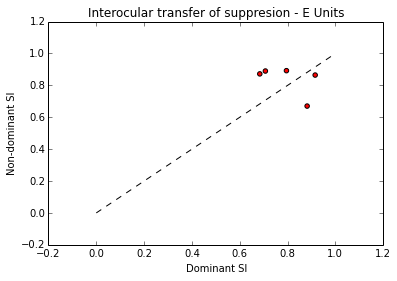

In [70]:
# dominant_SI_E = dom_surround_results / thresh_units_max_fr_E
# non_dom_SI_E = non_dom_surround_results / thresh_units_max_fr_E
dominant_SI_E = (thresh_units_max_fr_E - dom_surround_results) / thresh_units_max_fr_E
non_dom_SI_E = (thresh_units_max_fr_E - non_dom_surround_results) / thresh_units_max_fr_E

plt.figure()
plt.scatter(dominant_SI_E, non_dom_SI_E, c='r')
plt.xlabel('Dominant SI')
plt.ylabel('Non-dominant SI')
plt.title('Interocular transfer of suppresion - E Units')
plt.plot([0,1], [0,1], 'k--')
plt.savefig('results/interocular_transfer/fig-10a-nov-9-E-ring-3')

In [71]:
# Now do all the same stuff for the I units:

non_dom_surround_stim_I = np.zeros((len(thresh_units_I), N_pairs, N_pairs))
dom_surround_stim_I = np.copy(non_dom_surround_stim_I)
dom_crf_stim_I = np.copy(non_dom_surround_stim_I)
for i in range(len(thresh_units_I)):
    xi = thresh_units_I[i,0]
    yi = thresh_units_I[i,1]
    inner_d = thresh_units_sfs_I[i]
    outer_d = inner_d + 3
    centre = [dx*xi, dx*yi]
    ocularity = np.abs( np.round(OD_map[yi,xi]) - 1)
    non_dom_surround_stim_I[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, ocularity, OP_map, OD_map)
    dom_surround_stim_I[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, np.round(OD_map[yi,xi]), OP_map, OD_map)
    dom_crf_stim_I[i] = ssn.generate_ext_stimulus( ori, inner_d, [dx*xi, dx*yi], OP_map, OD_map, np.round(OD_map[yi,xi]))
                                                  
# Run simulations to analyze non dominant suppression:
non_dom_surround_results_I = np.zeros((len(thresh_units_I)))
dom_surround_results_I = np.copy(non_dom_surround_results_I)
for i in range(len(thresh_units_I)):
    xi = thresh_units_I[i,0]
    yi = thresh_units_I[i,1]
    h = non_dom_surround_stim_I[i] + dom_crf_stim_I[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    non_dom_surround_results_I[i] = r_I[-1,yi,xi]
    
    h = dom_surround_stim_I[i] + dom_crf_stim_I[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    dom_surround_results_I[i] = r_I[-1,yi,xi]                                                  

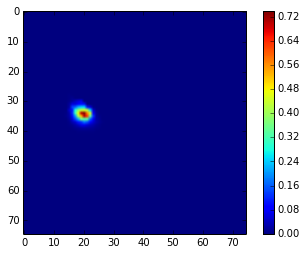

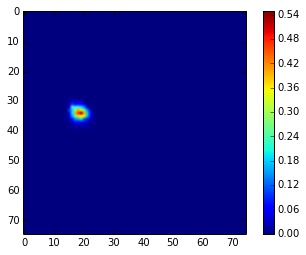

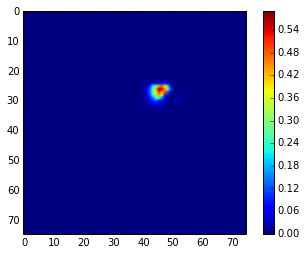

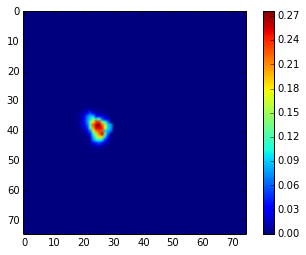

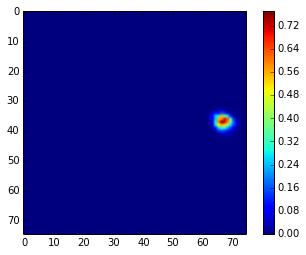

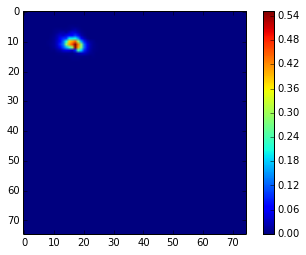

In [67]:
for i in range(len(thresh_units_I)):
    plt.figure()
    # plt.imshow(non_dom_surround_stim_I[i])
    plt.imshow(dom_crf_stim_I[i])
    # plt.imshow(non_dom_surround_stim_I[i] + dom_crf_stim_I[i])
    plt.colorbar()

[ 42.77673258   4.19726967  25.44725183  25.7131264   31.824489
  11.02796346]
[  2.73618894   2.90133734   4.4122586    0.93750639  11.94790934
   3.67288614]
[  9.73663055e+00   1.65748466e+00   2.37556965e+00   2.19428692e-28
   7.39295871e+00   5.09073671e+00]


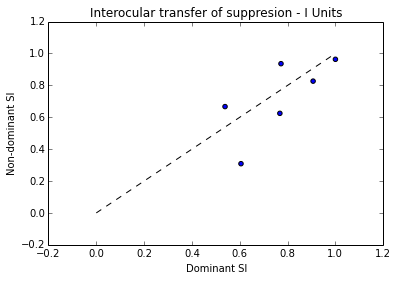

In [78]:
# dominant_SI_I = dom_surround_results_I / thresh_units_max_fr_I
# non_dom_SI_I = non_dom_surround_results_I / thresh_units_max_fr_I

dominant_SI_I = (thresh_units_max_fr_I - dom_surround_results_I) / thresh_units_max_fr_I
non_dom_SI_I = (thresh_units_max_fr_I - non_dom_surround_results_I) / thresh_units_max_fr_I

non_dom_SP_I = non_dom_surround_results_I / thresh_units_max_fr_I
print thresh_units_max_fr_I
print non_dom_surround_results_I
print dom_surround_results_I
plt.figure()
plt.scatter(dominant_SI_I[np.where(non_dom_SP_I <= 0.9)], non_dom_SI_I[np.where(non_dom_SP_I <= 0.9)], c='b')
plt.xlabel('Dominant SI')
plt.ylabel('Non-dominant SI')
plt.title('Interocular transfer of suppresion - I Units')
plt.plot([0,1], [0,1], 'k--')
# plt.savefig('results/interocular_transfer/fig-10a-nov-9-I-ring-3')

In [73]:
# Examine which units suppress below 90% with non dom surround:
print "E Units: "
print thresh_units_E[np.where(non_dom_SI_E <= .9),:]
print '-----------'
print "I Units: "
print thresh_units_I[np.where(non_dom_SI_I <= .9),:]

E Units: 
[[[ 67.  12.]
  [ 20.  33.]
  [ 13.  62.]
  [ 23.  57.]
  [ 20.  70.]]]
-----------
I Units: 
[[[ 20.  33.]
  [ 13.  62.]
  [ 20.  70.]
  [ 22.   6.]]]


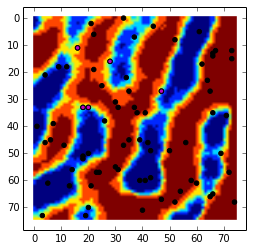

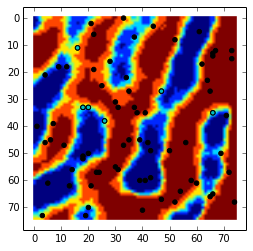

In [81]:
plt.figure()
plt.imshow(OD_map)
for i in range(len(selected_units)):
    plt.scatter(selected_units[i,0], selected_units[i,1], c='k')
    
for i in range(len(thresh_units_E)):
    plt.scatter(thresh_units_E[i,0], thresh_units_E[i,1], c='m')

plt.figure()
plt.imshow(OD_map)
for i in range(len(selected_units)):
    plt.scatter(selected_units[i,0], selected_units[i,1], c='k')
for i in range(len(thresh_units_I)):
    plt.scatter(thresh_units_I[i,0], thresh_units_I[i,1], c='c')
    

In [ ]:
print "SFS_E mean: ", np.mean(sfs_E)
print "SFS_E std: ", np.std(sfs_E)
print "SFS_I mean: ", np.mean(sfs_I)
print "SFS_I std: ", np.std(sfs_I)

In [85]:
# Try the whole set of simulations again without using the individual 
# summation field sizes

sfs_E_mean = np.mean(sfs_E)
sfs_I_mean = np.mean(sfs_I)

non_dom_stimuli = np.zeros((len(selected_units), 2, N_pairs, N_pairs))
dom_crf_stimuli = np.zeros((len(selected_units), 2, N_pairs, N_pairs))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ocularity = np.abs( np.round(OD_prefs[i]) - 1)
    non_dom_stimuli[i,0,:,:] = ssn.generate_ext_stimulus( ori, sfs_E_mean, [dx*xi, dx*yi], OP_map, OD_map, ocularity)
    non_dom_stimuli[i,1,:,:] = ssn.generate_ext_stimulus( ori, sfs_I_mean, [dx*xi, dx*yi], OP_map, OD_map, ocularity)
    
    dom_crf_stimuli[i,0,:,:] = ssn.generate_ext_stimulus( ori, sfs_E_mean, [dx*xi, dx*yi], OP_map, OD_map, np.round(OD_prefs[i]) )
    dom_crf_stimuli[i,1,:,:] = ssn.generate_ext_stimulus( ori, sfs_I_mean, [dx*xi, dx*yi], OP_map, OD_map, np.round(OD_prefs[i]) )
        
non_dom_results = np.zeros((len(selected_units), 2))
dom_crf_results = np.zeros((len(selected_units), 2))
st = time.time()
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    h = non_dom_stimuli[i,0,:,:]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    non_dom_results[i,0] = r_E[-1,yi,xi]
    non_dom_results[i,1] = r_I[-1,yi,xi]

#     h = non_dom_stimuli[i,1,:,:]
#     [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
#     non_dom_results[i,1] = r_I[-1,yi,xi]
    
    h = dom_crf_stimuli[i,0,:,:]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    dom_crf_results[i,0] = r_E[-1,yi,xi]
    
#     h = dom_crf_stimuli[i,1,:,:]
#     [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
#     dom_crf_results[i,1] = r_I[-1,yi,xi]

threshold = 1 # threshold for firing rate 
print "E units above threshold: %d" % len(selected_units[np.where(non_dom_results[:,0]>=threshold),:][0])
print selected_units[np.where(non_dom_results[:,0]>=threshold),:]
print '-----------'
print "I units above threshold: %d" % len(selected_units[np.where(non_dom_results[:,1]>=threshold),:][0])
print selected_units[np.where(non_dom_results[:,1]>=threshold),:]

thresh_units_E = selected_units[np.where(non_dom_results[:,0]>=threshold),:][0]
thresh_units_I = selected_units[np.where(non_dom_results[:,1]>=threshold),:][0]

# thresh_units_sfs_E = sfs_E[np.where(non_dom_results[:,0]>=threshold)]
# thresh_units_sfs_I = sfs_I[np.where(non_dom_results[:,1]>=threshold)]

thresh_units_max_fr_E = dom_crf_results[np.where(non_dom_results[:,0]>=threshold)]
thresh_units_max_fr_I = dom_crf_results[np.where(non_dom_results[:,1]>=threshold)]

# Now find which units which are above threshold also suppress below 90% with non-dom surround:
non_dom_surround_stim_E = np.zeros((len(thresh_units_E), N_pairs, N_pairs))
dom_surround_stim_E = np.copy(non_dom_surround_stim_E)
dom_crf_stim_E = np.copy(non_dom_surround_stim_E)
for i in range(len(thresh_units_E)):
    xi = thresh_units_E[i,0]
    yi = thresh_units_E[i,1]
    inner_d = sfs_E_mean
    outer_d = inner_d + 3
    centre = [dx*xi, dx*yi]
    ocularity = np.abs( np.round(OD_map[yi,xi]) - 1)
    non_dom_surround_stim_E[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, ocularity, OP_map, OD_map)
    dom_surround_stim_E[i] = ssn.generate_ring_stimulus(OP_map[yi,xi], inner_d, outer_d, centre, np.round(OD_map[yi,xi]), OP_map, OD_map)
    dom_crf_stim_E[i] = ssn.generate_ext_stimulus( ori, inner_d, [dx*xi, dx*yi], OP_map, OD_map, np.round(OD_map[yi,xi]) )
    
# Run simulations to analyze non dominant suppression:
non_dom_surround_results = np.zeros((len(thresh_units_E)))
dom_surround_results = np.copy(non_dom_surround_results)
for i in range(len(thresh_units_E)):
    xi = thresh_units_E[i,0]
    yi = thresh_units_E[i,1]
    h = non_dom_surround_stim_E[i] + dom_crf_stim_E[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    non_dom_surround_results[i] = r_E[-1,yi,xi]
    
    h = dom_surround_stim_E[i] + dom_crf_stim_E[i]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    dom_surround_results[i] = r_E[-1,yi,xi]  
    
print "Elapsed time: %d seconds" % (time.time()-st)

E units above threshold: 5
[[[ 20.  33.]
  [ 18.  33.]
  [ 47.  27.]
  [ 28.  16.]
  [ 16.  11.]]]
-----------
I units above threshold: 6
[[[ 20.  33.]
  [ 18.  33.]
  [ 47.  27.]
  [ 26.  38.]
  [ 66.  35.]
  [ 16.  11.]]]
Elapsed time: 5642 seconds


In [89]:
print thresh_units_max_fr_E[:,0]

[ 2.59860721  1.91524915  4.07010827  7.80690617  4.32823014]


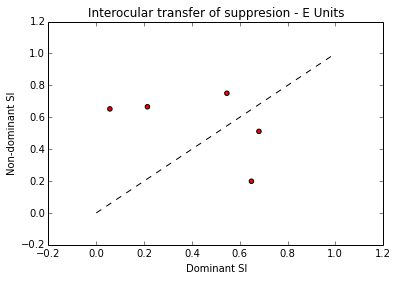

In [90]:
dominant_SI_E = (thresh_units_max_fr_E[:,0] - dom_surround_results) / thresh_units_max_fr_E[:,0]
non_dom_SI_E = (thresh_units_max_fr_E[:,0] - non_dom_surround_results) / thresh_units_max_fr_E[:,0]

plt.figure()
plt.scatter(dominant_SI_E, non_dom_SI_E, c='r')
plt.xlabel('Dominant SI')
plt.ylabel('Non-dominant SI')
plt.title('Interocular transfer of suppression - E Units')
plt.plot([0,1], [0,1], 'k--')
# plt.savefig('results/interocular_transfer/fig-10a-nov-9-E-ring-3')

In [94]:
print dominant_SI_I
print '----'
print non_dom_SI_I

[ 0.77238489  0.60510408  0.9066473   1.          0.76769592  0.53837925]
----
[ 0.93603558  0.30875603  0.82661159  0.96353977  0.6245687   0.66694792]


In [111]:
model_data_x = np.concatenate((dominant_SI_E, dominant_SI_I))
model_data_y = np.concatenate((non_dom_SI_E, non_dom_SI_I))

webb_data = np.array([[0.3538, 0.3214],
[0.5513, 0.2271],
[0.5154, 0.5064],
[0.5641, 0.5681],
[0.6077, 0.5605],
[0.7179, 0.6172],
[0.7487, 0.6865],
[0.8282, 0.6406],
[0.8923, 0.5459],
[0.9282, 0.5690],
[0.6308, 0.4093],
[0.7385, 0.4557],
[0.7923, 0.4866],
[0.7385, 0.5352],
[0.9974, 0.9846]])

In [126]:
d, prob = ks_test3.ks2d2s(webb_data[:,0], webb_data[:,1], model_data_x, model_data_y)

print "K-S statistic D:, ", d
print "Significance level: ", prob

Running a 2D, 2 sample Kolmogorov-Smirnov test!
K-S statistic D:,  0.481818181818
Significance level:  0.0813826648221


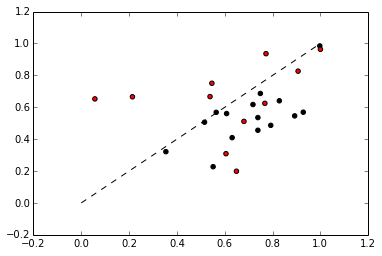

In [127]:
plt.figure()
plt.scatter(webb_data[:,0], webb_data[:,1], c='k')
plt.scatter(model_data_x, model_data_y, c='r')
plt.plot([0,1], [0,1], 'k--')